# GR5293 - Proj2 - Group9
## NLP with tweets related to COVID
#### NLP pipeline with sentiment prediction
* Tokenization
    > Split text into tokens(sentences or words), for this question, we split the document into sentence for automatic summarization, and words for sentiment analysis and topic modeling
* Screen out stop words and other meaningless corpus
* Lemmatization
    > Here we only use lemmatization rather than stemming is because lemmatization keeps the interpretability of words with their context. While stemming might lead to incorrect meaning. It is important to make morphological analysis of the words. 
* EDA: wordCloud with different sentiment
    > Identify what poeple with different emotions were considering about
* EDA: Word2vec with Clustering
    > Word2Vec: Effective for detecting the synonymous words or suggesting additional words for a partial sentence

    Clustering methods: K-means + DBScan

    Use all the words in a specific part-of-speech from all the documents (e.g. all nouns / all adj.s)
* (word2vec w/ recommendation)?
* Topic Modeling: Feature extraction by TFIDF + Latent Dirichlet Allocation
    Build a pipeline with KFoldCV to find the best topic number
* Automatic summrization
    > Identify what were most people thinking about or tweeting for
* Sentiment Analysis: Classification for sentiment(5 classes: Neutral / Positive / Extremely Positive / Negative / Extremely Negative)
  
    Potential Model: lightGBM / stacking / BERT?
#### Preprocessing
* Integer encoding since there's ordinal relation between negative, positive and neutral

In [60]:
import numpy
import numpy as np
import pandas as pd
import sklearn
import nltk
import spacy
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display
import seaborn as sns
import time
import os
import re
import string
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%xmode plain
os.getcwd()

Exception reporting mode: Plain


'/Users/kangshuoli/Documents/VScode_workspace/GR5293/EODS-Project2-Group9/EODS_Project2_Group9/doc'

### Read in filtered data

In [21]:
df = pd.read_csv("../data/Corona_NLP_filtered.csv")
df.drop(
    "Unnamed: 0", 
    axis = 1,
    inplace = True
)
df

,OriginalTweet,Sentiment,Tweet_filtered,Word_list,Senten_list,Senten_list_filtered
0,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...,"['advice', 'talk', 'neighbour', 'family', 'exc...",['advice Talk to your neighbours family to exc...,['advice talk to your neighbours family to exc...
1,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth give elderly d...,"['coronavirus', 'australia', 'woolworth', 'giv...",['Coronavirus Australia: Woolworths to give el...,['coronavirus australia woolworths to give eld...
2,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,"['food', 'stock', 'one', 'empty', 'please', 'd...",['My food stock is not the only one which is e...,['my food stock is not the only one which is e...
3,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak im paranoi...,"['ready', 'go', 'supermarket', 'covid', 'outbr...","['Me, ready to go at supermarket during the #C...",['me ready to go at supermarket during the cov...
4,As news of the regionÂs first confirmed COVID...,Positive,news regionâ  first confirmed covid case came...,"['news', 'regionâ', '\x92', 'first', 'confirme...",['As news of the regionÂ\x92s first confirmed ...,['as news of the regionâ\x92s first confirmed ...
...,...,...,...,...,...,...
39228,Meanwhile In A Supermarket in Israel -- People...,Positive,meanwhile supermarket israel people dance sing...,"['meanwhile', 'supermarket', 'israel', 'people...",['Meanwhile In A Supermarket in Israel -- Peop...,['meanwhile in a supermarket in israel people...
39229,Did you panic buy a lot of non-perishable item...,Negative,panic buy lot nonperishable item echo need foo...,"['panic', 'buy', 'lot', 'nonperishable', 'item...",['Did you panic buy a lot of non-perishable it...,['did you panic buy a lot of nonperishable ite...
39230,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,asst prof economics talking recent research co...,"['asst', 'prof', 'economics', 'talking', 'rece...","[""Asst Prof of Economics was on talking about ...",['asst prof of economics was on talking about ...
39231,Gov need to do somethings instead of biar je r...,Extremely Negative,gov need somethings instead biar je rakyat ass...,"['gov', 'need', 'somethings', 'instead', 'biar...","[""Gov need to do somethings instead of biar je...",['gov need to do somethings instead of biar je...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39233 entries, 0 to 39232
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   OriginalTweet         39233 non-null  object
 1   Sentiment             39231 non-null  object
 2   Tweet_filtered        39231 non-null  object
 3   Word_list             39231 non-null  object
 4   Senten_list           39230 non-null  object
 5   Senten_list_filtered  39229 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


### Data Cleaning
* Most done in data_cleaning.ipynb
* Drop rows with missing values

In [25]:
df.dropna(
    axis = 0, 
    how = "any", 
    inplace = True
)
df.index = np.arange(df.shape[0], dtype = int)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39229 entries, 0 to 39228
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   OriginalTweet         39229 non-null  object
 1   Sentiment             39229 non-null  object
 2   Tweet_filtered        39229 non-null  object
 3   Word_list             39229 non-null  object
 4   Senten_list           39229 non-null  object
 5   Senten_list_filtered  39229 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


## Word-level Analysis
1. wordCloud
2. word2Vec w/ clustering

## Document-level / Sentence-level Analysis

1. Sentence-level automatic summarization
* Extractive summarization: pick the original sentence which can represent the main focus of the whole document
* Abstractive summarization: generate new sentences for summary
    > Purely extractive summaries often times give better results compared to automatic abstractive summaries. This is because of the fact that abstractive summarization methods cope with problems such as semantic representation, inference and natural language generation which are relatively harder than data-driven approaches such as sentence extraction.

We use frequency-driven approch here. 

##### Extractive method w/ TFIDF
##### Model: Centroid-based summarization (simplified)

In [27]:
# Centroid-based summarization

# Sentence cleaning
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def lower(text):
    low_text = text.lower()
    return low_text

def remove_num(text):
    remove = re.sub(r'\d+', '' ,text)
    return remove

def remove_punctuation(text):
    clean_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

def remove_at(text):
    at = re.compile(r'@.+?\s')
    no_at = re.sub(at, '', text)
    return no_at

stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

def remove_stop_word(sent):
    word_list = word_tokenize(sent)
    word_list_filtered = [word for word in word_list if word not in stop_words]
    word_list_lemmatized = [wnl.lemmatize(item) for item in word_list_filtered]
    return ' '.join(word_list_lemmatized)



# combine all sentences into one list
sentence_list = []
sentence_list_filtered = []
for i in np.arange(df.shape[0]):
    curr_corpus = df.loc[i, "OriginalTweet"]
    curr_senten_list = sent_tokenize(curr_corpus)
    # lemmatize + stop_words
    curr_senten_list_cleaned = [remove_at(
        remove_urls(
            remove_html(
                remove_num(
                    remove_punctuation(
                        lower(
                            remove_stop_word(item)
                        )
                    )
                )
            )
        )
    ) for item in curr_senten_list]
    sentence_list.extend(curr_senten_list)
    sentence_list_filtered.extend(curr_senten_list_cleaned)


tfidf_sum = TfidfVectorizer(
    norm = "l2", # The cosine similarity between two vectors is their dot product when l2 norm has been applied.
    stop_words = 'english', # already filtered
    preprocessor = None, 
    lowercase = True, # already lowered
    max_df = 50, 
    min_df = 20, 
    ngram_range = (1,1)
)
tfidf_word = tfidf_sum.fit_transform(df["Tweet_filtered"])
vocab_sum = tfidf_sum.get_feature_names()
vocab_sum = [x.replace(' ', '_') for x in vocab_sum]


# sum all the tfidf score for each word
tfidf_word_all_doc = pd.Series(
    np.array(tfidf_word.sum(axis = 0)).reshape(-1, 1).ravel(), 
    index = vocab_sum
)

# set a threshold to filter out the word that are not important
threshold = tfidf_word_all_doc.median()
print(f'TF-IDF threshold: {threshold:0.4f}')

# for each sentence get the sentence centroid score by summing up the word score
def get_centroid_score(sent_):
    score = 0
    word_list = sent_tokenize(sent_)
    for word in word_list:
        if word in vocab_sum: # get rid of some mis-tokenized words
            if tfidf_word_all_doc[word] >= threshold: # TFIDF scores are below a threshold are removed
                score += tfidf_word_all_doc[word]
    return score

# get the sentence score by filtered sentence
sentence_score_dict = {}
for i, curr_senten in enumerate(sentence_list_filtered):
    sentence_score_dict[sentence_list[i]] = get_centroid_score(curr_senten)

# get the ranked tweet score
tweet_score_dict = {}
for i, curr_senten in enumerate(sentence_list_filtered):
    sentence_score_dict[sentence_list[i]] = get_centroid_score(curr_senten)

TF-IDF threshold: 20.5310


In [29]:
from nltk.tokenize import word_tokenize as nlkt_word_tokenize
from scipy.spatial.distance import cosine
from numpy.linalg import norm

# get cosine similarity
def similarity(a, b):
    if np.count_nonzero(a) != 0 and np.count_nonzero(b) != 0:
        return (a.T @ b) / (norm(a)*norm(b))
    else: 
        return 0

def processing_sentence(text):
    stop_words = set(stopwords.words('english'))
    sentences = sent_tokenize(text)
    sentences_cleaned = []
    for sent in sentences:
        words = word_tokenize(sent)
        words = [w for w in words if w not in string.punctuation]
        words = [w for w in words if not w.lower() in stop_words]
        words = [w.lower() for w in words]
        sentences_cleaned.append(" ".join(words))
    return sentences_cleaned

def get_tf_idf(sentences):
    vectorizer = CountVectorizer()
    sent_word_matrix = vectorizer.fit_transform(sentences)

    transformer = TfidfTransformer(
        norm = None, 
        sublinear_tf = False, 
        smooth_idf = False
    )
    tfidf = transformer.fit_transform(sent_word_matrix)
    tfidf = tfidf.toarray()

    centroid_vector = tfidf.sum(0)
    centroid_vector = np.divide(centroid_vector, centroid_vector.max())

    feature_names = vectorizer.get_feature_names()

    relevant_vector_indices = np.where(centroid_vector > 0.3)[0]

    word_list = list(np.array(feature_names)[relevant_vector_indices])
    return word_list

#Populate word vector with all embeddings.
#This word vector is a look up table that is used
#for getting the centroid and sentences embedding representation.
def word_vectors_cache(sentences, embedding_model):
    word_vectors = dict()
    for sent in sentences:
        words = word_tokenize(sent)
        for w in words:
            word_vectors.update({w: embedding_model.wv[w]})
    return word_vectors

# Sentence embedding representation with sum of word vectors
def build_embedding_representation(words, word_vectors, embedding_model):
    embedding_representation = np.zeros(embedding_model.vector_size, dtype = "float32")
    word_vectors_keys = set(word_vectors.keys())
    count = 0
    for w in words:
        if w in word_vectors_keys:
            embedding_representation = embedding_representation + word_vectors[w]
            count += 1
    if count != 0:
       embedding_representation = np.divide(embedding_representation, count)
    return embedding_representation

def summarize(text, emdedding_model):
    raw_sentences = sent_tokenize(text)
    clean_sentences = processing_sentence(text)
    # for i, s in enumerate(raw_sentences):
    #     print(i, s)
    # for i, s in enumerate(clean_sentences):
    #     print(i, s)
    centroid_words = get_tf_idf(clean_sentences)
    print(len(centroid_words), centroid_words)
    word_vectors = word_vectors_cache(clean_sentences, emdedding_model)
    #Centroid embedding representation
    centroid_vector = build_embedding_representation(centroid_words, word_vectors, emdedding_model)
    sentences_scores = []
    for i in range(len(clean_sentences)):
        scores = []
        words = clean_sentences[i].split()

        #Sentence embedding representation
        sentence_vector = build_embedding_representation(words, word_vectors, emdedding_model)

        #Cosine similarity between sentence embedding and centroid embedding
        score = similarity(sentence_vector, centroid_vector)
        sentences_scores.append((i, raw_sentences[i], score, sentence_vector))
    sentence_scores_sort = sorted(sentences_scores, key=lambda el: el[2], reverse=True)
    # for s in sentence_scores_sort:
    #     print(s[0], s[1], s[2])
    count = 0
    sentences_summary = []
    #Handle redundancy
    for s in sentence_scores_sort:
        if count > 100:
            break
        include_flag = True
        for ps in sentences_summary:
            sim = similarity(s[3], ps[3])
            if sim > 0.95:
                include_flag = False
        if include_flag:
            sentences_summary.append(s)
            count += len(s[1].split())

        sentences_summary = sorted(sentences_summary, key=lambda el: el[0], reverse = False)

    summary = "\n".join([s[1] for s in sentences_summary])
    print(f'Summary: \n{summary}')
    return summary

text = ""
for i in np.arange(df.shape[0]):
    text += df.loc[i, "OriginalTweet"]

clean_sentences = processing_sentence(text)
words = []
for sent in clean_sentences:
    words.append(nlkt_word_tokenize(sent))
model = Word2Vec(words, min_count = 1, sg = 1) # training by: skip-gram w/ no word ignored
summarize(text, model)
# 7min

14 ['19', 'amp', 'co', 'consumer', 'coronavirus', 'covid', 'covid19', 'food', 'grocery', 'https', 'people', 'prices', 'store', 'supermarket']
Summary: 
#coronavirus #COVID19 #toiletpaper #apocalypse2020Had to fetch some forgotten items from the grocery store &amp; SHOCKED by the # people out &amp; about.
#coronavirus #Covfefe19 #coronapocalypseThe beginning of our week of confinement https://t.co/m8emJT5xPe We have, as of yet, to be in a grocery store or other public place.
We will help you get your restaurant or grocery store in compliance with Covid 19.
#Report #COVID19 #ContingenyPlanning :  https://t.co/j66kLlka5h https://t.co/8cx61kXAC9@USAttyBash @TheJusticeDept Hmmm... A worker in a San Antonio grocery store has tested positive for Covid 19.
#coronapocalypse #coronavirus #NationalEmergency #COVID19 #QuarantineAndChillRest assured, we have plenty of food that will continue to reach grocery stores on a regular basis as we continue to respond to #COVID?19.


'#coronavirus #COVID19 #toiletpaper #apocalypse2020Had to fetch some forgotten items from the grocery store &amp; SHOCKED by the # people out &amp; about.\n#coronavirus #Covfefe19 #coronapocalypseThe beginning of our week of confinement https://t.co/m8emJT5xPe We have, as of yet, to be in a grocery store or other public place.\nWe will help you get your restaurant or grocery store in compliance with Covid 19.\n#Report #COVID19 #ContingenyPlanning :  https://t.co/j66kLlka5h https://t.co/8cx61kXAC9@USAttyBash @TheJusticeDept Hmmm... A worker in a San Antonio grocery store has tested positive for Covid 19.\n#coronapocalypse #coronavirus #NationalEmergency #COVID19 #QuarantineAndChillRest assured, we have plenty of food that will continue to reach grocery stores on a regular basis as we continue to respond to #COVID?19.'

In [14]:
# save the sentence_score_dict
import pickle
with open('centroid_based_sentence_score_ver1.pkl', 'wb') as file:
    pickle.dump(sentence_score_dict, file)
file.close()
'''
ver1:
    norm = "l2", # The cosine similarity between two vectors is their dot product when l2 norm has been applied.
    stop_words = 'english', # already filtered
    preprocessor = None, 
    lowercase = True, # already lowered
    max_df = 0.001, 
    min_df = 10, 
    ngram_range = (1,10)

''' 
print(f'Saved!')

Saved!


In [28]:
# sort by importance value in descending order
sentence_score_dict_sorted = {k: v for k, v in sorted(
    sentence_score_dict.items(), key=lambda item: item[1], 
    reverse = True
)[:50]}

for sentence, score in sentence_score_dict_sorted.items():
    print(sentence, score)

he was so excited ?? 36.30346874416296
Excited! 36.30346874416296
RETWEET! 34.402026556188666
is desperate. 33.86312101050457
Paracetamol only. 33.65921451542796
RN: ? 33.495131851648246
Carers. 33.42546531233133
WONDERFUL! 33.353029765498775
Wonderful! 33.353029765498775
Lovely. 32.3038066601519
Brilliant! 32.23556114394227
Chocolate 
2. 31.561648314067686
Sleep more." 31.155661191813007
SUSPENDED. 30.969638716026427
Bottled. 30.959285328199456
Duty. 30.738654453089755
Ya. 30.616861919976646
Ca 30.289249793340876
Locked in too? 30.269070270454932
Bless them all. 29.90517164178371
Bless you! 29.90517164178371
Bless you :) 29.90517164178371
Immunity ?. 29.605360953515095
Bitch??? 29.110643928328095
LIFT! 28.871270288250685
Luck? 28.550359398544362
Overall. 28.48822775364674
but angry ? 26.714676490627426
Dude... 26.55934987072801
Publix. 26.242056201467715
Ffs 25.54760887409805
FFS. 25.54760887409805
Plea 25.50292462042094
ET. 25.493171967816245
y tho ? 25.31744363451076
Film at 11! 24.

2. Document-level sentiment classification
* Use stacking
    First layer: XGBoost / RF / AdaBoost

In [30]:
df.Sentiment.value_counts()

Positive              11057
Negative               9740
Extremely Positive     6928
Extremely Negative     5766
Neutral                5738
Name: Sentiment, dtype: int64

In [33]:
sentiment_encode= {
    'Extremely Negative': -2, 
    'Negative': -1, 
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
}
y = df.Sentiment.replace(sentiment_encode)
print(y.value_counts(normalize = True))

 1    0.281858
-1    0.248286
 2    0.176604
-2    0.146983
 0    0.146269
Name: Sentiment, dtype: float64


In [34]:
from lightgbm import LGBMClassifier

x_train, x_test, y_train, y_test = train_test_split(
    df.Tweet_filtered, y, 
    test_size = 0.2, 
    stratify = y, 
    random_state = 42
)

### Build pipeline
* tfidf + truncated SVD(pca) + lgb classifier
* tfidf + truncated SVD(pca) + stackingClassifier

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=20, lgbc__n_estimators=100, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.2min
[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=20, lgbc__n_estimators=200, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.2min
[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=20, lgbc__n_estimators=100, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.2min
[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=20, lgbc__n_estimators=200, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=4

/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=20, lgbc__n_estimators=200, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.2min


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=20, lgbc__n_estimators=100, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.2min


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=20, lgbc__n_estimators=100, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.2min
[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=20, lgbc__n_estimators=200, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.2min


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=20, lgbc__n_estimators=200, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.2min


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=50, lgbc__n_estimators=100, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.3min
[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=50, lgbc__n_estimators=100, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.3min
[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=50, lgbc__n_estimators=100, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=42, svd__n_components=100, svd__random_state=42, tfidf__max_df=0.5, tfidf__min_df=30; total time= 3.3min
[CV] END lgbc__importance_type=gain, lgbc__learning_rate=0.005, lgbc__max_depth=50, lgbc__n_estimators=200, lgbc__n_jobs=-1, lgbc__num_iterations=3000, lgbc__random_state=4

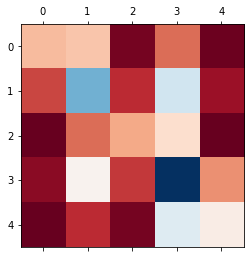

In [58]:
pipe_lgbc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD()), 
    ('lgbc', LGBMClassifier())
])

n_components_list = [int(item) for item in np.logspace(0.2, 2.5, num = 20)]


param_grid_lgbc = {
    'tfidf__min_df':[30],
    'tfidf__max_df':[0.4],
    'svd__n_components':n_components_list,
    'svd__random_state':[42],
    'lgbc__n_estimators':[100],
    'lgbc__num_iterations':[800],
    'lgbc__max_depth':[50, 100], 
    'lgbc__learning_rate':[0.005], 
    'lgbc__n_jobs':[-1], 
    'lgbc__random_state':[42], 
    'lgbc__importance_type':['gain']
}

gs_pipe_lgbc = GridSearchCV(
    pipe_lgbc, 
    param_grid_lgbc, 
    scoring = 'accuracy',
    cv = 5, 
    n_jobs = -1, 
    verbose = 2
).fit(x_train, y_train)


clf = gs_pipe_lgbc.best_estimator_
cv_result = gs_pipe_lgbc.cv_results_
test_score = clf.score(x_test, y_test)
best_index = gs_pipe_lgbc.best_index_
best_train_score = gs_pipe_lgbc.best_score_
best_validation_score = cv_result['mean_test_score'][best_index]
best_params = gs_pipe_lgbc.best_params_




print(f'Best param: \n{gs_pipe_lgbc.best_params_}')
print(f'Best score: \n{gs_pipe_lgbc.best_score_:0.4f}')

y_predict = gs_pipe_lgbc.best_estimator_.predict(x_test)
print(f'Test Accuracy:{accuracy_score(y_test, y_predict):.4f}')
my_cmap = cm.get_cmap('RdBu')
conf_mx = confusion_matrix(y_test, y_predict)
plt.matshow(conf_mx, cmap = my_cmap)
plt.show()

#### Learning curve

--------------------------------------
Current n_components: 398


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.424529
Test,0.425950


--------------------------------------
Current n_components: 476


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.427652
Test,0.430920


--------------------------------------
Current n_components: 569


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.430392
Test,0.431685


--------------------------------------
Current n_components: 681


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.431252
Test,0.433214


--------------------------------------
Current n_components: 814


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.432145
Test,0.427224


--------------------------------------
Current n_components: 974


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.430934
Test,0.439587


--------------------------------------
Current n_components: 1165


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.430265
Test,0.434744


--------------------------------------
Current n_components: 1394


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.428831
Test,0.435126


--------------------------------------
Current n_components: 1668


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.429022
Test,0.434234


--------------------------------------
Current n_components: 1995


/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of arg

,scores
Validation,0.42899
Test,0.43245


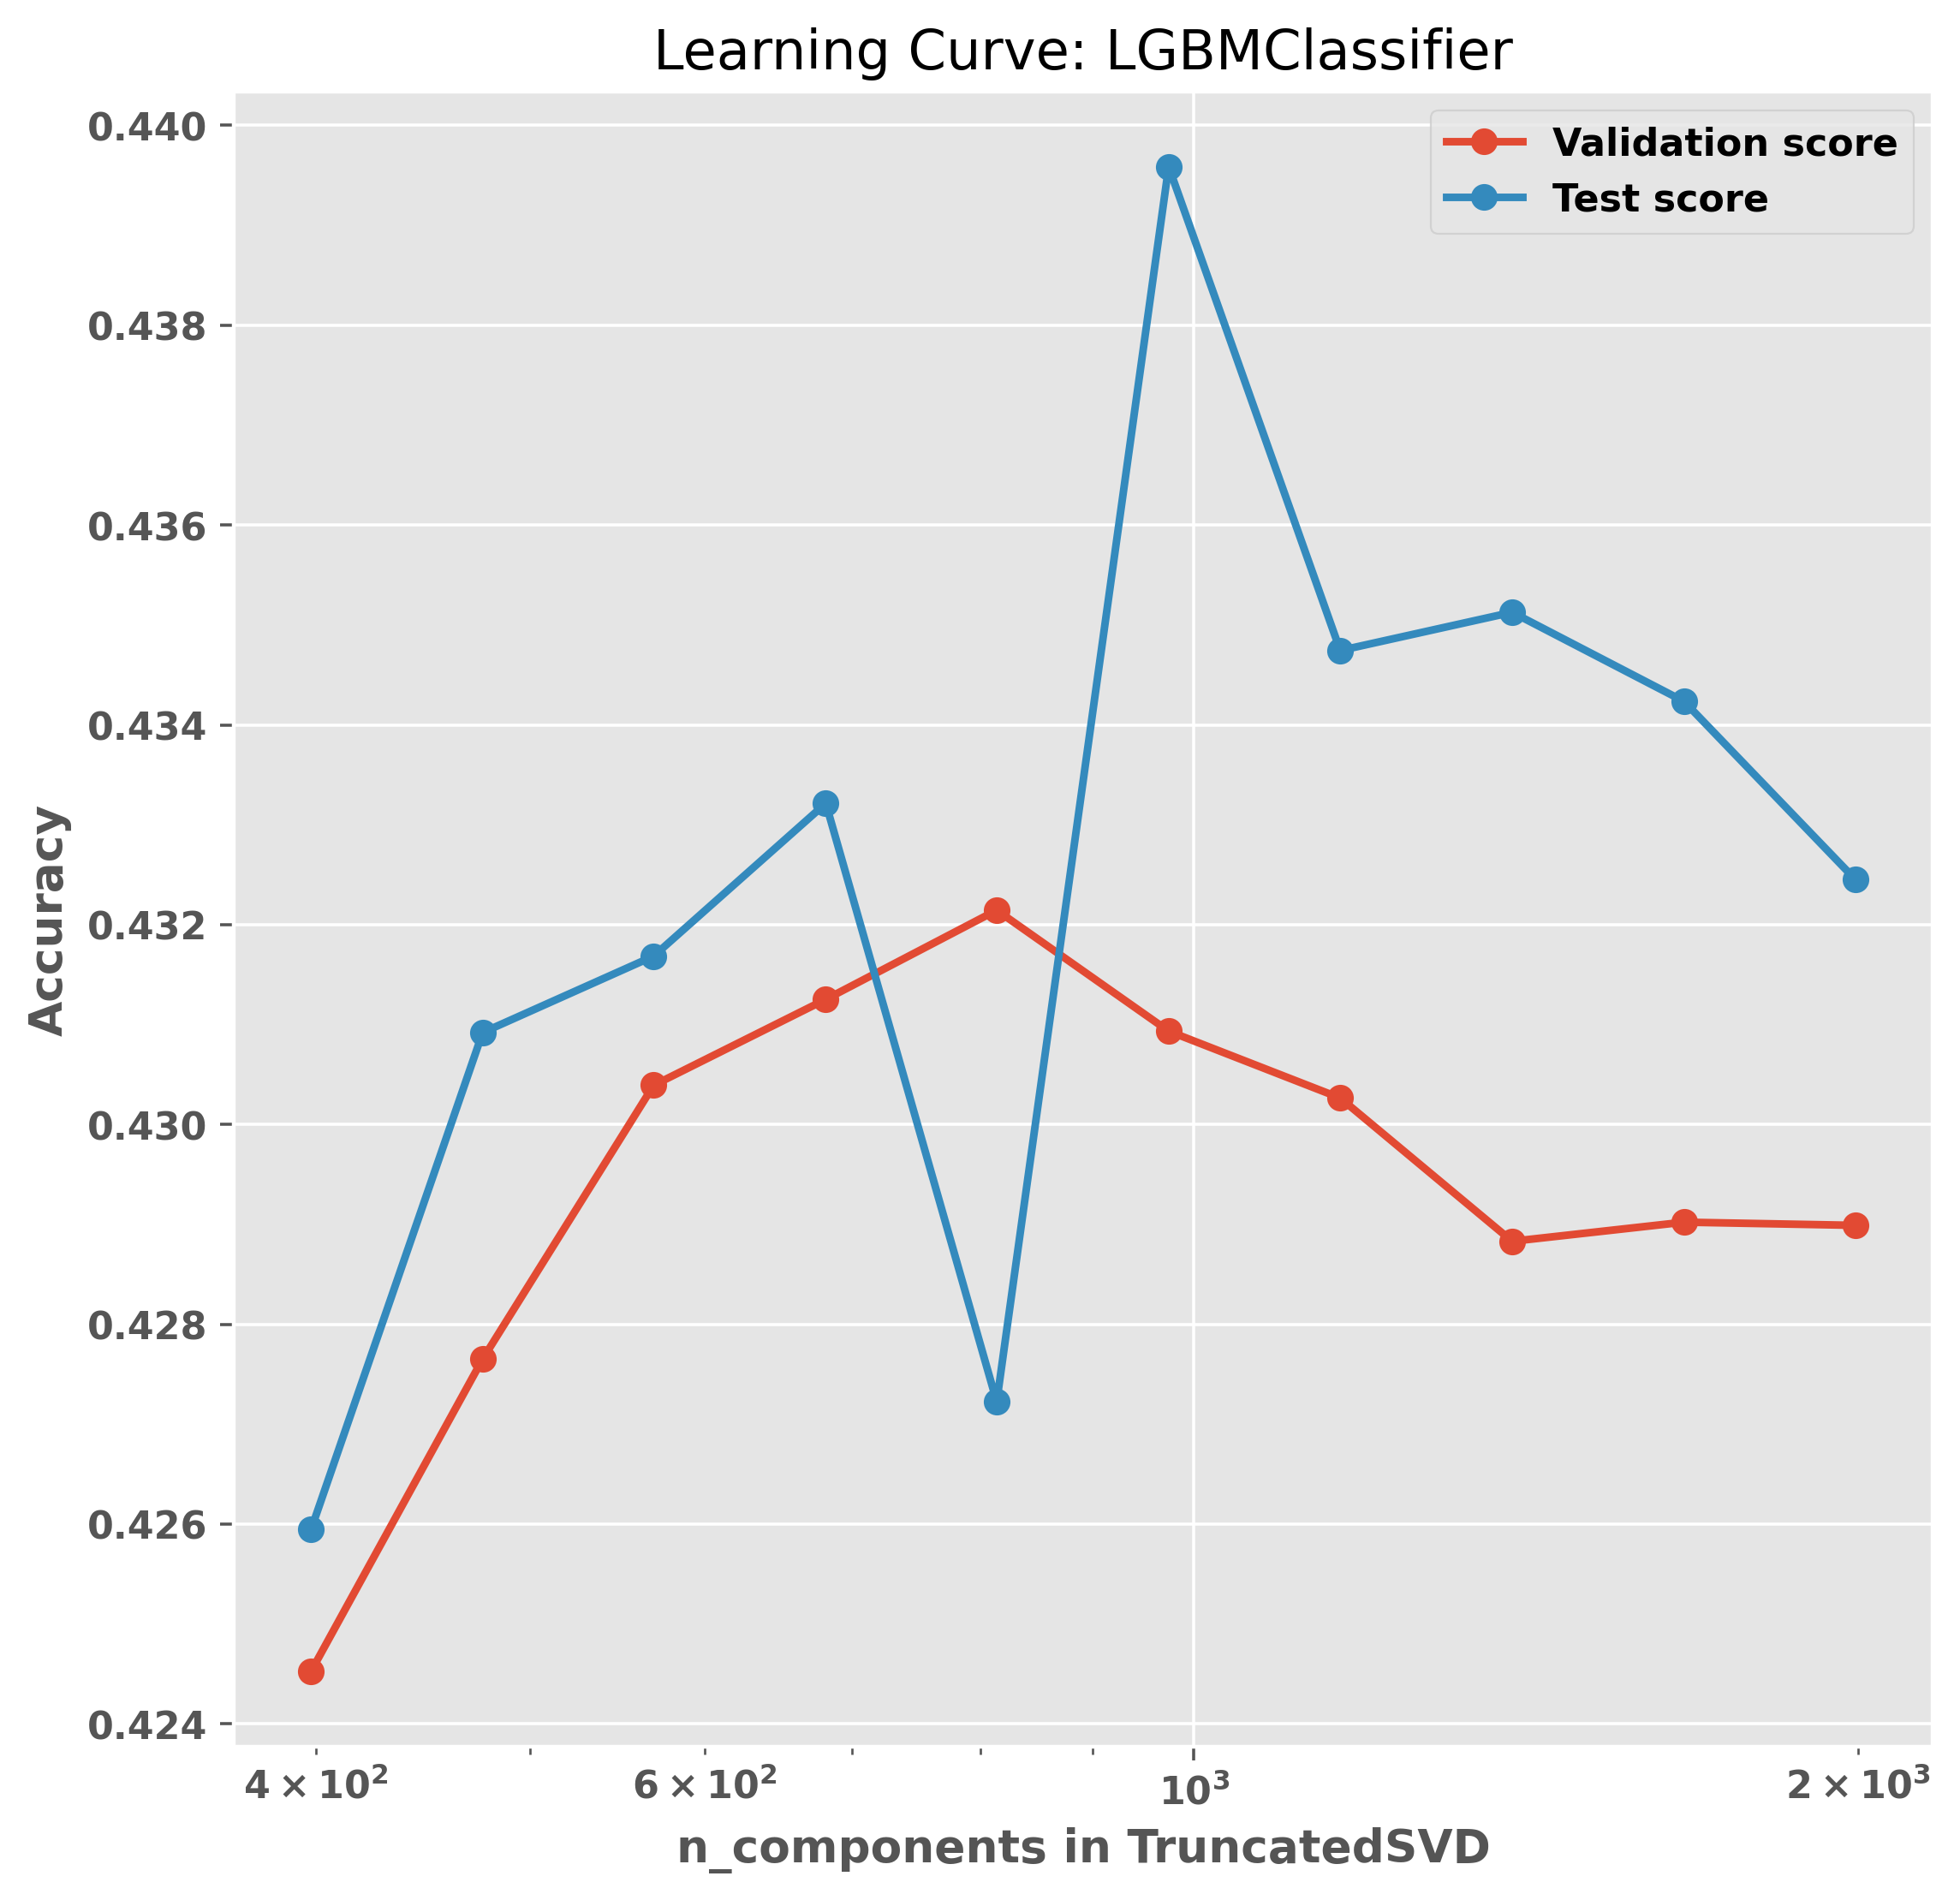

In [75]:
# num of raw features: 2134

# n_components_list = [int(item) for item in np.logspace(0.2, 2.5, num = 20)] # ver1
n_components_list = [int(item) for item in np.logspace(2.6, 3.3, num = 10)] # ver2

def get_validation_test_score_list(n_components_list):
    validation_error_list = []
    test_error_list = []
    for value in n_components_list:
        print(f'--------------------------------------')
        print(f'Current n_components: {value}')
        pipe_lgbc = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('svd', TruncatedSVD()), 
            ('lgbc', LGBMClassifier())
        ])
        
        param_grid_lgbc = {
            'tfidf__min_df':[30],
            'tfidf__max_df':[0.4],
            'svd__n_components':[value],
            'svd__random_state':[42],
            'lgbc__n_estimators':[200],
            'lgbc__num_iterations':[600],
            'lgbc__max_depth':[100], 
            'lgbc__learning_rate':[0.01], 
            'lgbc__n_jobs':[-1], 
            'lgbc__random_state':[42], 
            'lgbc__importance_type':['gain']
        }

        gs_pipe_lgbc = GridSearchCV(
            pipe_lgbc, 
            param_grid_lgbc, 
            scoring = 'accuracy',
            cv = 5, 
            n_jobs = -1, 
            verbose = 0, 
            return_train_score = True
        ).fit(x_train, y_train)


        clf = gs_pipe_lgbc.best_estimator_
        cv_result = gs_pipe_lgbc.cv_results_
        temp_test_score = clf.score(x_test, y_test)
        # temp_best_index = gs_pipe_lgbc.best_index_
        temp_best_validation_score = gs_pipe_lgbc.best_score_
        # temp_best_validation_score = cv_result['mean_test_score'][temp_best_index]
        temp_best_params = gs_pipe_lgbc.best_params_

        result_df = pd.DataFrame(
            data = [[temp_best_validation_score],
                    [temp_test_score]], 
            columns = ["scores"], 
            index = ["Validation", "Test"]
        )
        display(result_df)

        validation_error_list.append(temp_best_validation_score)
        test_error_list.append(temp_test_score)
    return n_components_list, validation_error_list, test_error_list

def plot_learning_curve(n_var_list, validation_score_list, test_score_list):
    plt.style.use('ggplot')
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    fig, ax = plt.subplots(1, 1, figsize = (8, 8), dpi = 320)
    ax.plot(n_var_list, validation_score_list, 'o-', label = "Validation score", linewidth = 2)
    ax.plot(n_var_list, test_score_list, 'o-', label = "Test score", linewidth = 2)
    ax.legend()
    ax.set_xscale("log")
    ax.set_title('Learning Curve: LGBMClassifier')
    ax.set_xlabel('n_components in TruncatedSVD')
    ax.set_ylabel('Accuracy')
    plt.show()
    pass

n_components_list, validation_error_list, test_error_list = get_validation_test_score_list(n_components_list)
plot_learning_curve(n_components_list, validation_error_list, test_error_list)

In [76]:
#save learning curve
# Ver1/Ver2 -> param_grid_lgbc = {
#             'tfidf__min_df':[30],
#             'tfidf__max_df':[0.4],
#             'svd__n_components':[value],
#             'svd__random_state':[42],
#             'lgbc__n_estimators':[200],
#             'lgbc__num_iterations':[600],
#             'lgbc__max_depth':[100], 
#             'lgbc__learning_rate':[0.01], 
#             'lgbc__n_jobs':[-1], 
#             'lgbc__random_state':[42], 
#             'lgbc__importance_type':['gain']
#         }
# with open('learning_curve_ver1.pkl', 'wb') as file:
#     pickle.dump([n_components_list, validation_error_list, test_error_list], file)
# file.close()
with open('learning_curve_ver2.pkl', 'wb') as file:
    pickle.dump([n_components_list, validation_error_list, test_error_list], file)
file.close()
# Ver1 + Ver2



In [ ]:
pipe_stacking = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD()), 
    ('stacking', StackingClassifier(
        estimators = [
            ('xgb', xgb.XGBClassifier(
                n_estimator = 1000, 
                max_depth = 30, 
                learning_rate = 0.01, 
                verbosity = 0, 
                booster = 'gbtree', 
                n_jobs = -1, 
                random_state = 42, 
                reg_alpha = 0.5, 
                importance_type = "gain"
            )), 
            ('rf', RandomForestClassifier(
                n_estimators = 600, 
                max_depth = 20, 
                random_state = 42, 
                n_jobs = -1
            )), 
            ('ada', AdaBoostClassifier(
                n_estimators = 600, 
                random_state = 42, 
                n_jobs = -1
            )), 
            ('lr', LogisticRegression(
                penalty = 'l1', 
                dual = True, 
                C = 1, 
                random_state = 42, 
                n_jobs = -1
            ))
        ]
    ))
])

param_grid_lgbc = {
    'tfidf__min_df':[10, 20, 30],
    'tfidf__max_df':[0.2, 0.3, 0.4],
    'svd__n_components':[100, 200],

}

gs_pipe_lgbc = GridSearchCV(
    pipe_lgbc, 
    param_grid_lgbc, 
    scoring = 'accuracy',
    cv = 5, 
    n_jobs=-1
).fit(x_train, y_train)

print(f'Best param: \n{gs_pipe_lgbc.best_params_}')
print(f'Best socre: \n{gs_pipe_lgbc.best_score_:0.4f}')

y_predict = gs_pipe_lgbc.best_estimator_.predict(x_test)
print(f'Accuracy Score:{accuracy_score(y_test, y_predict):.4f}')
my_cmap = cm.get_cmap('RdBu')
conf_mx = confusion_matrix(y_test, y_predict)
plt.matshow(conf_mx, cmap = my_cmap)
plt.show()